# Experiment with extracting shape info from confocal images of fish embryos

In [2]:
from aicsimageio import AICSImage
import os 
import glob2 as glob

# define path to image
image_name = "2024_StayGold_10x_s018_T0"
read_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/yx1_samples/20230412/"
image_path = read_path + image_name + ".ome.tif"

# set path to segmentation
seg_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/20230412/segmentation/"

# set save path
pcd_path = "/Users/nick/Dropbox (Cole Trapnell's Lab)/Nick/morphSeq/data/yx1_pcd/20230412/"

# make save directory
if not os.path.isdir(pcd_path):
    os.makedirs(pcd_path)

# get list of segmentation files
seg_list = glob.glob(seg_path + "*.tif")

# set time points
time_ind = 1
imObject = AICSImage(seg_list[time_ind])


In [3]:
import plotly.graph_objects as go
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
import plotly.express as px
from skimage import data
from skimage import filters
from skimage.segmentation import active_contour
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.morphology import black_tophat, skeletonize, convex_hull_image 
from skimage.morphology import disk
import skimage
import scipy
import numpy as np

# get resolution
res_raw = imObject.physical_pixel_sizes
res_array = np.asarray(res_raw)
res_array = np.insert(res_array, 0, 1)
pixel_size_z = 20#res_array[1]
pixel_size_x = 1#res_array[2]
pixel_size_y = 1#res_array[3]

# extract raw image
imData = np.squeeze(imObject.data)

# resize image such that voxels are isotropic
z_rs_factor = pixel_size_z/pixel_size_x
ds_factor = 2
pixel_size_new = pixel_size_x / ds_factor
imData_rs = scipy.ndimage.zoom(imData, [z_rs_factor/ds_factor, 1/ds_factor, 1/ds_factor])

imDataBin = imData_rs>0

keep_indices = np.where(imDataBin ==1)

z_grid3, y_grid3, x_grid3 = np.meshgrid(range(0, imDataBin.shape[0]), 
                                        range(0, imDataBin.shape[1]), 
                                        range(0, imDataBin.shape[2]),
                                       indexing="ij")

# # calculate position of max point for each
x_surf3 = x_grid3[keep_indices]
y_surf3 = y_grid3[keep_indices]
z_surf3 = z_grid3[keep_indices]


In [4]:
import open3d as o3d

n_samples3 = x_surf3.size
xyz_array3 = np.concatenate((np.reshape(x_surf3, (n_samples3, 1)),
                             np.reshape(y_surf3, (n_samples3, 1)),
                             np.reshape(z_surf3, (n_samples3, 1))), axis=1)

dtype = o3d.core.float32
device = o3d.core.Device("CPU:0")

pcd3 = o3d.geometry.PointCloud()
pcd3.points = o3d.utility.Vector3dVector(xyz_array3)


In [5]:
import pyvista as pv

downpcd3 = pcd3.voxel_down_sample(voxel_size=2)

cl, ind = downpcd3.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)

# xyz_out = np.delete(xyz_array, ind, axis=0)
# xyz_in = xyz_array[ind]

pcd_in3 = downpcd3.select_by_index(ind)
xyz = np.asarray(pcd_in3.points)
pv_cloud3 = pv.PolyData(np.asarray(pcd_in3.points))
pv_cloud3.plot(jupyter_backend='ipygany', scalars=xyz[:, 2])

/Users/nick/miniforge3/envs/morphseq-env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

To simplify things, let's just focus on the first non-zero point at each xy position

In [6]:
max_z_val = np.max(imData_rs, axis=0)
max_z_pos = np.argmax(imData_rs, axis=0)

keep_indices2 = np.where(max_z_val>0)

y_grid2, x_grid2 = np.meshgrid(
                                range(0, imDataBin.shape[1]), 
                                range(0, imDataBin.shape[2]),
                               indexing="ij")

# # calculate position of max point for each
x_surf2 = x_grid2[keep_indices2]
y_surf2 = y_grid2[keep_indices2]
z_surf2 = max_z_pos[keep_indices2]

n_samples2 = x_surf2.size
xyz_array2 = np.concatenate((np.reshape(x_surf2, (n_samples2, 1)),
                             np.reshape(y_surf2, (n_samples2, 1)),
                             np.reshape(z_surf2, (n_samples2, 1))), axis=1)

pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(xyz_array2)

downpcd2 = pcd2.voxel_down_sample(voxel_size=3)

cl, ind = downpcd2.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.5)

# xyz_out = np.delete(xyz_array, ind, axis=0)
# xyz_in = xyz_array[ind]

pcd_in2 = downpcd2.select_by_index(ind)
xyz2 = np.asarray(pcd_in2.points)
pv_cloud2 = pv.PolyData(np.asarray(pcd_in2.points))
pv_cloud2.plot(jupyter_backend='ipygany', scalars=xyz2[:, 2])

/Users/nick/miniforge3/envs/morphseq-env/lib/python3.10/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float64". A coerced copy has been created.
  warnings.warn(


AppLayout(children=(VBox(children=(HTML(value='<h3></h3>'), Dropdown(description='Colormap:', options=(('BrBG'…

In [7]:
alpha = 30
dl_3d_mesh = pv_cloud2.delaunay_2d(alpha=alpha)
# dl_3d_mesh = alphashape.alphashape(xyz_in, alpha=8)
dl_3d_mesh.fill_holes(200, inplace=True)
smooth = dl_3d_mesh#.smooth_taubin(n_iter=50, pass_band=0.2)
# smooth.plot(show_edges=True, jupyter_backend='ipygany')
smooth.plot(show_edges=True, jupyter_backend='ipygany')

AppLayout(children=(VBox(children=(HTML(value='<h3>Data</h3>'), Dropdown(description='Colormap:', options=(('B…

**Experiment with Gaussian Process Regression as a way to smooth and interpolate the data prior to meshing**

In [8]:
import napari_process_points_and_surfaces as nppas
import pyclesperanto_prototype as cle
import vedo

# set time points
time_ind = 27
imObject = AICSImage(seg_list[time_ind])
imData = np.squeeze(imObject.data)
# resize image such that voxels are isotropic
z_rs_factor = pixel_size_z/pixel_size_x
ds_factor = 8
pixel_size_new = pixel_size_x / ds_factor
imData_rs2 = scipy.ndimage.zoom(imData, [z_rs_factor/ds_factor, 1/ds_factor, 1/ds_factor])

im_binary = imData_rs2>0

embSurf = nppas.all_labels_to_surface(im_binary)

 ━━━━━━━━━━━━━━━━━━━━━━ elapsed: 1m16s (1104.5 it/s)        1m15s (1103.3 it/s)        king .....


(array([[  1.3463652,  46.780983 ,  22.672756 ],
        [  1.8602695,  46.668724 ,  23.168442 ],
        [  1.5820512,  47.105965 ,  22.951086 ],
        ...,
        [ 40.5      , 130.       , 243.       ],
        [ 40.499744 , 129.98375  , 248.0003   ],
        [ 40.499638 , 129.98549  , 250.00023  ]], dtype=float32),
 array([[    2,     1,     0],
        [    2,     0,     3],
        [    4,     0,     1],
        ...,
        [83392, 83373, 83368],
        [83374, 83393, 83370],
        [83393, 83374, 83371]]))
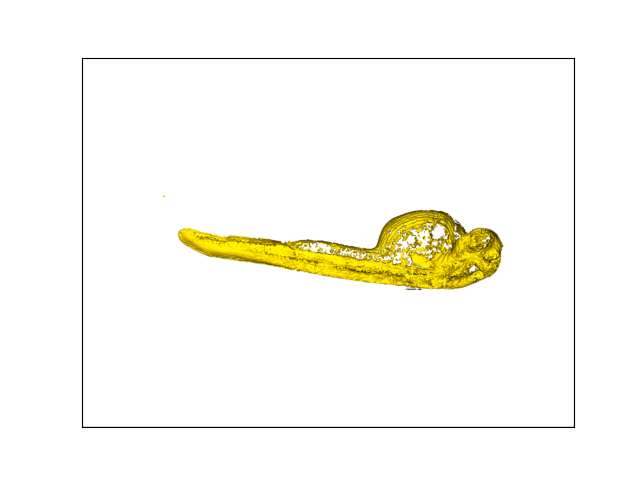

In [10]:
smoothed_surface = nppas.smooth_surface_moving_least_squares_2d(embSurf, smoothing_factor=0.2)
smoothed_surface

(array([[  1.3463652,  46.780983 ,  22.672756 ],
        [  1.8602695,  46.668724 ,  23.168442 ],
        [  1.5820512,  47.105965 ,  22.951086 ],
        ...,
        [ 40.5      , 130.       , 243.       ],
        [ 40.499744 , 129.98375  , 248.0003   ],
        [ 40.499638 , 129.98549  , 250.00023  ]], dtype=float32),
 array([[   2,    1,    0],
        [   2,    0,    3],
        [   4,    0,    1],
        ...,
        [2177, 2131, 2129],
        [2185, 2183, 2237],
        [2184, 2237, 2183]]))
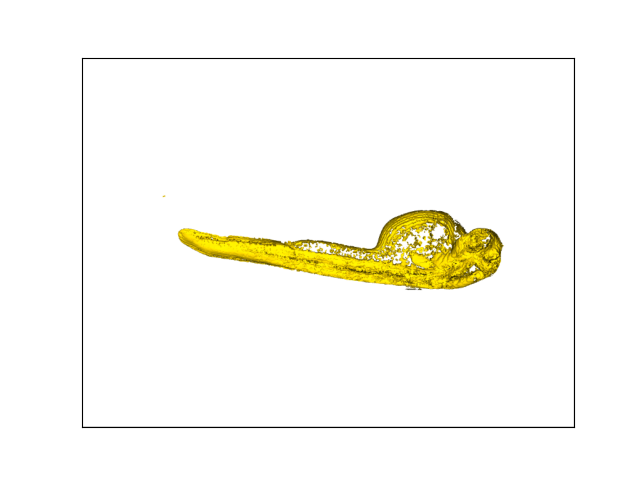

In [11]:
nppas.fill_holes_in_surface(smoothed_surface, size_limit=300)

(array([[  2.8944879,  89.52143  , 266.86444  ],
        [  2.6492836,  93.284424 , 271.37393  ],
        [  2.0208771,  94.426254 , 267.82535  ],
        ...,
        [ 35.18774  , 103.28049  , 318.88617  ],
        [ 33.28581  , 106.40932  , 320.48843  ],
        [ 37.313377 , 105.401405 , 314.73264  ]], dtype=float32),
 array([[  0,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8],
        ...,
        [796, 794, 792],
        [791, 795, 794],
        [796, 791, 794]]))
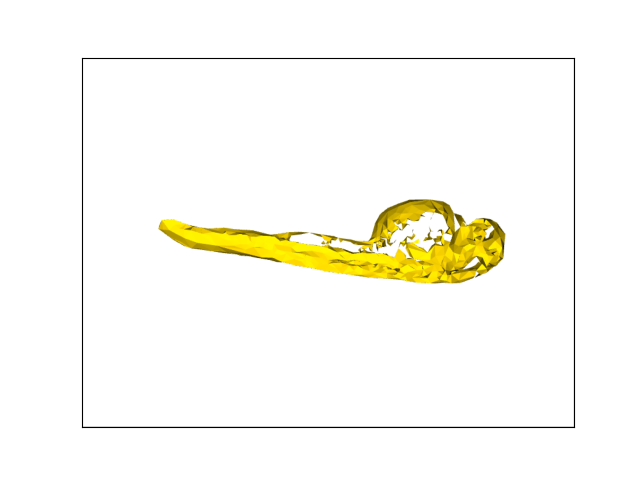

In [31]:
simplified_surface2 = nppas.decimate_quadric(smoothed_surface, fraction=0.01)
simplified_surface2

**Let's see if we can fill gaps using linear interpolation**

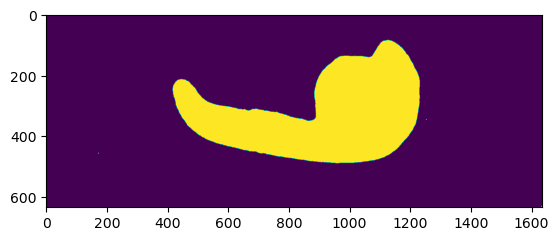

In [36]:
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing,  # noqa
                                white_tophat)

# first, generate 3D mask to identify interior pixels that we wish to interpolate
fish_mask = (np.max(imDataBin, axis=0) == 1)*1

# use morphological closure operation to fill in shape
footprint = disk(15)
fish_closed = closing(fish_mask, footprint)

# plt.imshow(fish_mask)
plt.imshow(fish_closed)


In [ ]:
from scipy import interpolate

# identify "holes" for which not a single pixel nonzero exists 
query_indices = np.where((fish_closed==1) & (fish_mask!=1))[0]
ref_indices = np.where(fish_mask==1)[0]
print(len(candidate_indices))
print(len(ref_indices))

f = interpolate.interp2d(xyz_array2[:, 0], xyz_array2[:, 1], xyz_array2[:, 2], kind='linear')
x_query = x_grid2[query_indices]
y_query = y_grid2[query_indices]
z_query = f(x_query, y_query)

Try fitting to the surface points only

(array([[0.0000e+00, 6.2950e+02, 1.6340e+03],
        [5.0000e-01, 6.3000e+02, 1.6340e+03],
        [0.0000e+00, 6.3000e+02, 1.6335e+03],
        ...,
        [1.6900e+02, 3.9800e+02, 1.1795e+03],
        [1.6900e+02, 3.9800e+02, 1.1805e+03],
        [1.6900e+02, 3.9850e+02, 1.1800e+03]], dtype=float32),
 array([[     2,      1,      0],
        [     1,      3,      0],
        [     5,      4,      1],
        ...,
        [536716, 536713, 536714],
        [536717, 536715, 536713],
        [536717, 536713, 536716]]))
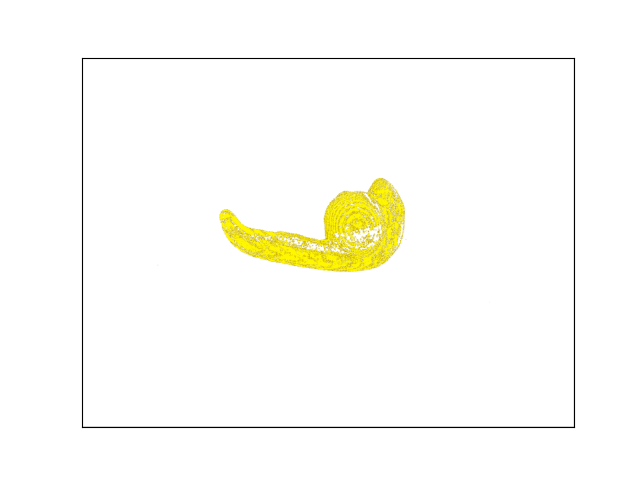

In [24]:
surf_mask_array = np.zeros(imData_rs.shape)
sub_i = np.roll(xyz_array2, 1, axis=1)
surf_indices = np.ravel_multi_index((1,2,2), imData_rs.shape)
surf_mask_array[xyz_array2[:, 2], xyz_array2[:, 1], xyz_array2[:, 0]] = 1

e_surf = nppas.all_labels_to_surface(surf_mask_array)
e_surf

In [30]:
e_surf.__dict__.keys()

dict_keys(['library_name', 'help_url'])

**Attempt 2:** downsample, interpolate, and then infer mesh

In [ ]:
# import numpy as np
# import scipy
# from scipy import interpolate


# f = interpolate.interp2d(xyz_ds_in[:, 0], xyz_ds_in[:, 1], xyz_ds_in[:, 2], kind='linear')


In [ ]:
# npoints = 150
# xg = np.linspace(np.min(xyz_ds_in[:, 0]), np.max(xyz_ds_in[:, 0]), npoints)
# yg = np.linspace(np.min(xyz_ds_in[:, 1]), np.max(xyz_ds_in[:, 1]), npoints)

# x_grid, y_grid = np.meshgrid(xg, yg)

# znew = f(xg, yg)

# xyz_interp = np.concatenate((np.reshape(x_grid, (x_grid.size, 1)), 
#                              np.reshape(y_grid, (x_grid.size, 1)),
#                              np.reshape(znew, (x_grid.size, 1))),
#                              axis=1)

# xyz_interp_filt = xyz_interp[np.where(xyz_interp[:, 2]<=350)]
# xyz_interp_filt = xyz_interp_filt[xyz_interp_filt[:, 2]>0]
# pv_cloud_interp = pv.PolyData(xyz_interp_filt)
# pv_cloud_interp.plot(jupyter_backend='ipygany')